## Individual Market Health Insurance and State Party Color

In this notebook we look at how State Governor's political party correlates with the number of health care options a an individual faces in the individual health insurance market.

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

In [2]:
# Set Printing Options
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

In [3]:
# Set paths and file names
projpath='C:\\Users\\l_gas\\Documents\\Development\\SpringBoard_DataScience\\CapstoneProj1'
stparty= projpath + "\\All_States_Governors_Party.csv"
stparty_all = pd.read_csv(stparty)
print(stparty_all.dtypes)
fed_stparty =stparty_all[stparty_all['Market_Reg']=='Federal']
own_stparty =stparty_all[stparty_all['Market_Reg']!='Federal']
plans_ahrf = (pd.read_json("./plans_ahrf.json"))
#print(plans_ahrf.dtypes)


State Code    object
Pparty        object
Market_Reg    object
dtype: object


### States Political Color

We identify the governor's political party at the beginning of 2018 for each of the states with Federally Regulated Individual Markets under the ACA. There are 9 states under a democratic governor, 29 states under a republican governor, and one state with an independent governor. Note that the number of democratic states opting to regulate their own markets is proportionally larger than the number of republican states choosing this option. Since we have just one state with an independent governor, we leave this state out of the analysis. 

The distribution of number of issuers and number of plans seems to vary across State party color. 

In [4]:
# Look at distribution of Political Party Governors in Federally vs State 
print("Count of States By Governor's Party")
print("Federally Regulated Markets")
print(fed_stparty.groupby('Pparty')['State Code'].count())
print("State Regulated Markets")
print(own_stparty.groupby('Pparty')['State Code'].count())


Count of States By Governor's Party
Federally Regulated Markets
Pparty
Democratic      9
Independent     1
Republican     29
Name: State Code, dtype: int64
State Regulated Markets
Pparty
Democratic    7
Republican    4
Name: State Code, dtype: int64


In [5]:
plans_data = pd.merge(left=plans_ahrf, right=fed_stparty, left_on='st', right_on='State Code')
plans_data_dr = plans_data[plans_data['Pparty']!='Independent']

### Distribution of number of issuers at the county level

                   count                       
Pparty        Democratic Independent Republican
count_issuers                                  
1                  223.0        28.0     1274.0
2                   89.0         NaN      645.0
3                  147.0         NaN       91.0
4                   22.0         NaN      151.0
5                    3.0         NaN       37.0
6                    NaN         NaN        5.0
7                    NaN         NaN        3.0
Total FIPS under Democratic Governor 484.0
Total FIPS under Independent Governor 28.0
Total FIPS under Republican Governor 2206.0
               Democratic (%)  Republican (%)  Independent (%)
count_issuers                                                 
1                   46.074380       57.751587            100.0
2                   18.388430       29.238441              NaN
3                   30.371901        4.125113              NaN
4                    4.545455        6.844968              NaN
5           

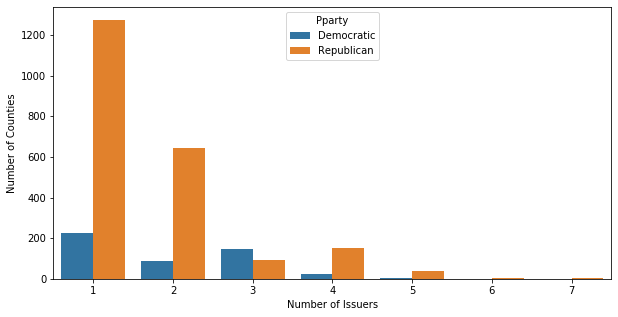

In [6]:
# 
party = ['Democratic','Independent','Republican']

# Get percent of FIPS with 1, 2, ... number of issuers
fips_by = pd.DataFrame(plans_data.groupby(['count_issuers','Pparty'])['fips'].agg(['count']).unstack())
print(fips_by)
fips_by_p = pd.DataFrame()
fips_by_p['Democratic (%)'] = fips_by['count']['Democratic']/fips_by['count']['Democratic'].sum()*100
fips_by_p['Republican (%)'] = fips_by['count']['Republican']/fips_by['count']['Republican'].sum()*100
fips_by_p['Independent (%)'] = fips_by['count']['Independent']/fips_by['count']['Independent'].sum()*100
print("Total FIPS under Democratic Governor", fips_by['count']['Democratic'].sum())
print("Total FIPS under Independent Governor",fips_by['count']['Independent'].sum())
print("Total FIPS under Republican Governor",fips_by['count']['Republican'].sum())

print(fips_by_p)

plt.figure(figsize=(10,5))
fips_by = plans_data_dr.groupby(['count_issuers','Pparty'])['fips'].agg(['count'])
fips_by=fips_by.reset_index(level=['count_issuers','Pparty'])
ax = sns.barplot(x="count_issuers", y="count", hue="Pparty", data=fips_by[fips_by['Pparty']!='Independent'])
_ = plt.xlabel("Number of Issuers")
_ = plt.ylabel("Number of Counties")
plt.savefig("Statistical Analysis-Insurers and Gov affiliation.png")


### Distribution of number of plans offered at the county level

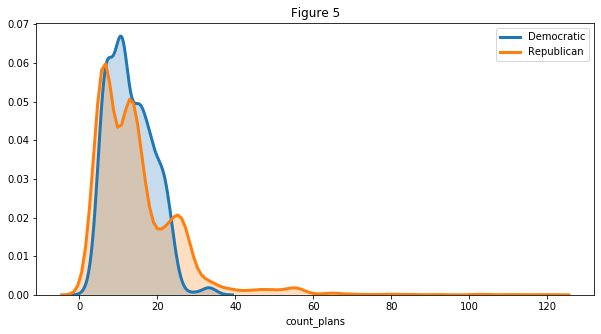

In [7]:
# List all political party state affiliations
party = ['Democratic','Republican']

plt.figure(figsize=(10,5))

for p in party:
    # Subset to the airline
    subset = plans_data_dr[plans_data_dr['Pparty'] == p]
    # Draw the density plot
    sns.distplot(subset['count_plans'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = p)
    
_ = plt.title("Figure 5")
plt.savefig("Statistical Analysis-figure 5.png")


## How Governor's Party Affiliation Relates to the Number of Plans Offered?

We are going to test the hypothesis that the expected number of plans in states with a Democratic Governor ($\mu_{D}$) is the same as the expected number of plans in states with a Republican Governor ($\mu_{R}$).

H0: $\mu_{D} = \mu_{R}$

We use a bootstrap approach to test this hypothesis. Under the null hypothesis the expected value of both means is the same, but their variance is not necessary the same. To generate bootstrap replicates we shift both distributions so their means are the same and we sample multiple times from it. We use $\tau = \mu_{D} - \mu_{R}$ to test the hypothesis.

We take 10,000 samples from the shifted distribution of plans, and for each simulation we compute $\hat \tau$ as the difference between both averages. Under the null hypothesis, observing a difference of -1.71 is highly unusual (p-value $\approx$ 0). Given that a state opts to have their individual health insurance market regulated by the Federal Government, States with Republican governors tend to have more plan options for individuals. 


In [8]:

# Get actual values for each group of states
plans_dem = (plans_data_dr.count_plans[plans_data.Pparty=='Democratic'])
plans_rep = (plans_data_dr.count_plans[plans_data.Pparty=='Republican'])
diff_mean = np.mean(plans_dem) - np.mean(plans_rep)
print("Avg Num of Plans - Democratic States", np.mean(plans_dem))
print("Avg Num of Plans - Republican States", np.mean(plans_rep))
print("Difference in Means", diff_mean)

# Shift the distributions
plans_dem_sft = plans_dem-plans_dem.mean()+plans_data_dr['count_plans'].mean()
plans_rep_sft = plans_rep-plans_rep.mean()+plans_data_dr['count_plans'].mean()

# Apply boostrap sampling to the shifted distributions
N_rep = 10000
diff_mean_bs = np.empty(N_rep)
for i in range(N_rep):
    plans_dem_bs = np.random.choice(plans_dem_sft,len(plans_dem_sft))
    plans_rep_bs = np.random.choice(plans_rep_sft,len(plans_rep_sft))
    diff_mean_bs[i] = np.mean(plans_dem_bs) - np.mean(plans_rep_bs)

p_val_meandiff0 = sum(diff_mean_bs<diff_mean)/len(diff_mean_bs)
print("p-value from testing equal means:")
print(p_val_meandiff0)


Avg Num of Plans - Democratic States 13.15702479338843
Avg Num of Plans - Republican States 14.868087035358114
Difference in Means -1.7110622419696835
p-value from testing equal means:
0.0


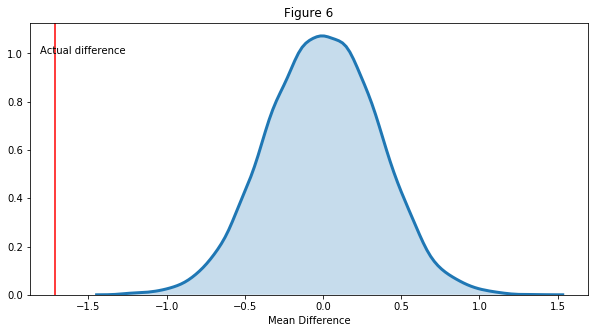

In [9]:
plt.figure(figsize=(10,5))

sns.distplot(diff_mean_bs, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
_ = plt.axvline(diff_mean, 0,1, color='r')
_ = plt.text(diff_mean-0.1,1,"Actual difference") 
_ = plt.xlabel("Mean Difference")
_ = plt.title("Figure 6")
plt.savefig("Statistical Analysis-figure 6.png")
